In [1]:
%pip install pandas
%pip install numpy
%pip install plotly
%pip install scipy
%pip install matplotlib


import pandas as pd
import numpy as np
import plotly as plt
import plotly.graph_objs as go
import scipy.signal as signal
import matplotlib.pyplot as plt
import time 

from scipy.signal import find_peaks, peak_widths, peak_prominences, chirp

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Determine the peaks.

In [2]:
dataframe = pd.read_csv('sampledata\sampledata.csv',index_col='ml') #name of file should be as input

#baseline correction

dataframe['mAU'] = dataframe['mAU'] - dataframe['mAU'].min() #subtracts the minimum value of mAU from all values of mAU
dataframe = dataframe.to_numpy() #converts dataframe to numpy array
print(dataframe) #prints the dataframe

x = dataframe[:,0] #x is the first column of the dataframe
peaks, _ = find_peaks(x, height=0) #finds the peaks in the dataframe'
print(peaks) 
print(len(peaks))



results_half = peak_widths(x, peaks, rel_height=0.5)  
results_full = peak_widths(x, peaks, rel_height=1) #finds the width of the peaks
prominences = peak_prominences(x, peaks)[0] #finds the prominences of the peaks

print(results_half[0]) #prints the width of the peaks
print(results_full[0])
print(prominences) #prints the prominences of the peaks


contour_heights = x[peaks] - prominences #finds the contour heights of the peaks




[[2.4640e+01]
 [2.4750e+01]
 [2.4380e+01]
 [2.3830e+01]
 [2.5720e+01]
 [2.5300e+01]
 [2.6580e+01]
 [2.9890e+01]
 [3.1060e+01]
 [3.0740e+01]
 [2.9800e+01]
 [2.8970e+01]
 [2.8260e+01]
 [2.7360e+01]
 [2.6730e+01]
 [2.6110e+01]
 [2.5500e+01]
 [2.4830e+01]
 [2.4320e+01]
 [2.3700e+01]
 [2.3210e+01]
 [2.2650e+01]
 [2.2120e+01]
 [2.1640e+01]
 [2.1130e+01]
 [2.0650e+01]
 [2.0180e+01]
 [1.9650e+01]
 [1.9270e+01]
 [1.8810e+01]
 [1.8430e+01]
 [1.7980e+01]
 [1.7680e+01]
 [1.7260e+01]
 [1.6920e+01]
 [1.6630e+01]
 [1.6210e+01]
 [1.5940e+01]
 [1.5620e+01]
 [1.5360e+01]
 [1.5080e+01]
 [1.4730e+01]
 [1.4470e+01]
 [1.4250e+01]
 [1.4000e+01]
 [1.3790e+01]
 [1.3520e+01]
 [1.3270e+01]
 [1.3100e+01]
 [1.2820e+01]
 [1.2620e+01]
 [1.2440e+01]
 [1.2240e+01]
 [1.2040e+01]
 [1.1810e+01]
 [1.1630e+01]
 [1.1470e+01]
 [1.1270e+01]
 [1.1130e+01]
 [1.0940e+01]
 [1.0770e+01]
 [1.0570e+01]
 [1.0450e+01]
 [1.0250e+01]
 [1.0190e+01]
 [9.9600e+00]
 [9.8400e+00]
 [9.6900e+00]
 [9.5400e+00]
 [9.4200e+00]
 [9.3000e+00]
 [9.11

Plotting the peaks.

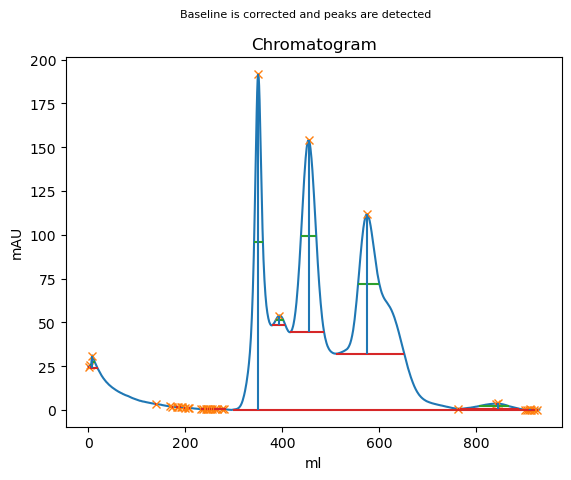

In [3]:
#plotting the peaks
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.hlines(*results_half[1:], color="C2")
plt.hlines(*results_full[1:], color="C3")
plt.vlines(x=peaks, ymin=contour_heights, ymax=x[peaks])
plt.title('Chromatogram')
plt.xlabel('ml')
plt.ylabel('mAU')
plt.suptitle('Baseline is corrected and peaks are detected', fontsize=8)
plt.show()

For printing the peaks to a csv file:

In [11]:
import csv

timestr = time.strftime("%Y%m%d-%H%M%S")

# Create a list to store the peak data
peak_data = []

# Append the peak data to the list
for i in range(len(peaks)):
    peak_data.append([i+1, peaks[i], x[peaks[i]]])
    continue 

# Convert the list to a dataframe
peakdata = pd.DataFrame(peak_data, columns=['Peak Number', 'Peak Time', 'Peak Height'])
peakdata = peakdata.set_index('Peak Number')
peakdata.to_csv('peakdata' + timestr + '.csv')







Calculating the MW of a hypothetical protein at each peak.

In [40]:
slope = float(input("Enter the slope of the standard curve: ")) #slope of the standard curve
intercept = float(input("Enter the intercept of the standard curve: ")) #intercept of the standard curve

MWdict = {} #dictionary to store the MW of the peaks

for i in range(len(peaks)):
    MW = (peaks[i]-(intercept)) / (slope)  ##need to change this to the standard, the slope is the -5 and the intercept is the 38.69, use the equation y=mx+b from the standard curve to find the MW of the various peaks
    
    print(peaks[i], MW)

timestr = time.strftime("%Y%m%d-%H%M%S") #creates a timestamp

df_MWdict = pd.DataFrame.from_dict(MWdict, orient='index') #converts the dictionary to a dataframe
df_MWdict.to_csv('molweights' + timestr + '.csv') #saves the dictionary as a csv file

Integrating each peak to determine the amount of protein eluted:

In [172]:
## for determining peak area

##note, some algorithms use peak minimia, others use peak maxima, so you may need to change the code depending on the algorithm you use

##peak area is the area under the curve of the peak, so you need to integrate the peak

##you can use the trapezoidal rule to integrate the peak



